# Парсинг вакансій та аналіз навичок Data Scientist: Від збору даних до інсайтів з українського тексту

У цьому уроці-майстер-класі ми зробимо один з типів Data Science проєктів, які зустрічаються в індустрії і який буде класним доповненням в Ваше портфоліо. 

**Задача:** Виявити, які конкретні навички прямо зараз є актуальними на ринку в обраному напрямі. В нашому випадку, Data Science.

Для цього нам необхідно
- Зібрати актуальні вакансії;
- Проаналізувати текст вакансій;
- Виявити навички в вакансіях;
- Зробити висновки.

В ході виконання завдання ми
- навчимося автоматично збирати дані з вебсайту (ця процедера називається "парсинг") за допомогою бібліотеки `selenium`;
- побудуємо візуалізацію WordCloud для аналізу текстів;
- познайомимось з поняттям n-грамів в обробці природньої мови;
- використаємо ChatGPT за АРІ аби "почистити" тексти вакансії від зайвої інформації і проставити лейбли для вакансій.

Збирати актуальні вакансії будемо в сфері Data Science з ресурсу DOU.ua, працюватимемо з українською та англіською мовами, та в результаті визначимо, які навички є найбільш затребуваними для фахівців з даних (data scientist).

В цьому уроці ми будемо працювати з web-сторінками, тому нам треба познайомитись з поняттям HTML.

## Коротке інтро, що таке HTML

**HTML (HyperText Markup Language)** — це стандартна мова розмітки, яка використовується для створення та структурування контенту вебсторінок в інтернеті. Вона дозволяє розмічати текст і додавати до нього різні елементи, такі як заголовки, абзаци, зображення, посилання, форми тощо.

Основні поняття HTML:

1. **Теги:**  
   HTML використовує теги для позначення різних елементів сторінки. Теги обмежуються кутовими дужками (`< >`) і зазвичай мають початковий і завершальний вигляд, наприклад:
   ```html
   <p>Це абзац тексту.</p>
   ```
   Деякі теги можуть бути самозакритими, наприклад, для зображень:
   ```html
   <img src="image.jpg" alt="Опис зображення" />
   ```

2. **Атрибути:**  
   Теги можуть містити атрибути, які надають додаткову інформацію про елемент. Наприклад, атрибут `src` вказує на джерело зображення, а `alt` описує його.
   ```html
   <img src="logo.png" alt="Логотип компанії" />
   ```

3. **Елементи:**  
   Елемент HTML складається з відкриваючого тегу, контенту та закриваючого тегу. Елементи можуть містити текст або інші елементи (вкладені елементи).
   ```html
   <h1>Заголовок сторінки</h1>
   ```

4. **Документна структура:**  
   Типовий HTML-документ має структуру з таких основних елементів:
   - `<!DOCTYPE html>` — вказує на тип документа.
   - `<html>` — кореневий тег документа.
   - `<head>` — містить метадані сторінки (стилі, метаінформація, скрипти).
   - `<body>` — містить видимий контент сторінки (текст, зображення, форми тощо).

   Наприклад:
   ```html
   <!DOCTYPE html>
   <html lang="uk">
     <head>
       <meta charset="UTF-8">
       <title>Назва сторінки</title>
     </head>
     <body>
       <h1>Вітаємо на нашому сайті!</h1>
       <p>Це перший абзац на сторінці.</p>
     </body>
   </html>
   ```

**Основна функція HTML** — це визначення структури і зовнішнього вигляду вебсторінки, яка потім відображається браузером. А от для додавання стилів (CSS) або інтерактивності (JavaScript) використовуються інші мови.

In [ ]:
!pip install selenium

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time
import requests
from tqdm import tqdm

import chromedriver_autoinstaller as chromedriver
chromedriver.install()

from selenium.webdriver.common.by import By

Зараз ми будемо парсити сторінку з вакансіями для Data Science, використовуючи бібліотеку Selenium. Першим кроком є відкриття вебсторінки, яка містить ці вакансії, за допомогою вебдрайвера Chrome. Для цього ми ініціалізуємо драйвер і вказуємо йому відкрити URL-адресу сторінки з вакансіями на DOU. 



In [3]:
driver = webdriver.Chrome()

driver.get('https://jobs.dou.ua/vacancies/?category=Data+Science')


На цьому етапі наш драйвер завантажує HTML-код сторінки, що дає нам можливість витягувати з нього необхідну інформацію. Далі ми будемо шукати конкретні елементи на сторінці, такі як заголовки вакансій, вимоги та інші деталі, і зберігати їх для подальшого аналізу.

Ми реалізуємо механізм для автоматичного завантаження більшої кількості вакансій на сторінці. Більшість сайтів, включаючи DOU, не показують всі вакансії одразу, тому користувачу потрібно натискати кнопку "Завантажити більше", щоб відобразити додаткові вакансії. Ми імітуємо дії користувача з `selenium`. І для цього робимо цикл:
1. У кожній ітерації циклу ми шукаємо елемент на сторінці, який відповідає кнопці для завантаження додаткових вакансій.
2. Після кожного кліка ми додаємо паузу в 3 секунди, щоб дати сторінці час на завантаження нових вакансій.
3. Якщо на сторінці більше немає кнопки "Завантажити більше" або виникає інша помилка (наприклад, елемент не знайдено), виконання програми перехоплює виключення, виводить повідомлення про завершення і виходить з циклу. 

In [4]:
while True:
    try:
        driver.find_element(By.CSS_SELECTOR, 'div.more-btn a').click()
        time.sleep(3)
    except Exception as ex:
        print(ex)
        print('End.')
        break

Message: element not interactable
  (Session info: chrome=128.0.6613.138)
Stacktrace:
0   chromedriver                        0x000000010222b338 chromedriver + 5096248
1   chromedriver                        0x0000000102222b6a chromedriver + 5061482
2   chromedriver                        0x0000000101dade01 chromedriver + 388609
3   chromedriver                        0x0000000101dfba85 chromedriver + 707205
4   chromedriver                        0x0000000101def8c6 chromedriver + 657606
5   chromedriver                        0x0000000101e1eef2 chromedriver + 851698
6   chromedriver                        0x0000000101def288 chromedriver + 656008
7   chromedriver                        0x0000000101e1f0ae chromedriver + 852142
8   chromedriver                        0x0000000101e3c250 chromedriver + 971344
9   chromedriver                        0x0000000101e1ec93 chromedriver + 851091
10  chromedriver                        0x0000000101dedc79 chromedriver + 650361
11  chromedriver     

На цьому етапі ми провантажили весь перелік вакансій обраної категорії і можемо завантажити їх у змінну.

Для зручності подальшої роботи ми використовуємо бібліотеку `BeautifulSoup`, яка має багато різного фукнціоналу для роботи з контентом в форматі html.

У даному випадку, `BeautifulSoup` виконує наступні дії:

1. **Парсинг HTML-контенту:**  
   Коли ми викликаємо `BeautifulSoup(content)`, бібліотека обробляє весь HTML-код, отриманий від вебдрайвера (`driver.page_source`). Вона перетворює його у зручний для роботи формат дерева, що дозволяє легко шукати та витягувати елементи сторінки.

2. **Створення об'єкта для подальшого аналізу:**  
   `soup` — це об'єкт, який містить всю структуру HTML. З його допомогою можна виконувати подальші операції: знаходити конкретні елементи сторінки, витягувати текстові дані, аналізувати посилання, таблиці, списки тощо.

Завдяки цьому ми можемо переходити до пошуку та витягування необхідної інформації зі сторінки, наприклад, посилань на вакансії, заголовків вакансій, вимог, імен компаній тощо.

In [6]:
content = driver.page_source
soup = BeautifulSoup(content)

In [8]:
# soup

In [ ]:
# driver.close()

У нас зараз вивантажена сторінка з усіма вакансіями і ми хочемо взяти посилання кожної з вакансій аби потім провантажити сторінки з описами вакансій. Для цього пишемо код, який шукає в html сторінки посилання на вакансії.

In [9]:
vac_list = soup.findAll('a',href=True, attrs={'class':'vt'})
project_href = [i['href'] for i in vac_list]

І такий результат ми отримали:

In [18]:
project_href

['https://jobs.dou.ua/companies/hiretop/vacancies/281076/',
 'https://jobs.dou.ua/companies/airadvisor/vacancies/280848/',
 'https://jobs.dou.ua/companies/softserve/vacancies/258163/',
 'https://jobs.dou.ua/companies/quantum/vacancies/230245/',
 'https://jobs.dou.ua/companies/mobidev/vacancies/280611/',
 'https://jobs.dou.ua/companies/globallogic/vacancies/280563/',
 'https://jobs.dou.ua/companies/airslate/vacancies/276180/',
 'https://jobs.dou.ua/companies/pharmbills/vacancies/270413/',
 'https://jobs.dou.ua/companies/dataroot/vacancies/277299/',
 'https://jobs.dou.ua/companies/modus-x/vacancies/276687/',
 'https://jobs.dou.ua/companies/pin-up-global/vacancies/280355/',
 'https://jobs.dou.ua/companies/privatbank/vacancies/276651/',
 'https://jobs.dou.ua/companies/quantum/vacancies/254781/',
 'https://jobs.dou.ua/companies/data-science-ua/vacancies/280255/',
 'https://jobs.dou.ua/companies/appflame/vacancies/269995/',
 'https://jobs.dou.ua/companies/united-tech/vacancies/280218/',
 'ht

Тепер нам треба завантажити кожне з цих посилань та взяти з них текст вакансій.

In [19]:
headers={"User-Agent": "HTTPie/3.1.0"}

In [20]:
vacs = {
    'link': [],
    'name': [],
    'desc': []
}
for link in tqdm(project_href):
    page = requests.get(link, headers=headers)
    soup = BeautifulSoup(page.content, "html.parser")
    vacs['link'].append(link)
    vacs['name'].append(soup.title.text)
    vacs['desc'].append(soup.select('div.vacancy-section')[0].text)
    time.sleep(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [01:05<00:00,  1.28s/it]


In [21]:
len(vacs['link'])

51

Далі вже все просто: записуємо результат в датафрейм і використовуємо для подальших цілей.

In [22]:
df = pd.DataFrame(vacs)

In [23]:
df.head()

,link,name,desc
0,https://jobs.dou.ua/companies/hiretop/vacancie...,Data Scientist (NLP & Large Language Models) в...,\nFull time RemoteBecause of inner security po...
1,https://jobs.dou.ua/companies/airadvisor/vacan...,"Data Analyst в AirAdvisor, віддалено | DOU",\nAirAdvisor is a flight compensation company ...
2,https://jobs.dou.ua/companies/softserve/vacanc...,Data Scientist (Generative AI); ID 90049 в Sof...,\nПРО НАС: SoftServe — це провідна ІТ-компанія...
3,https://jobs.dou.ua/companies/quantum/vacancie...,Data Science Engineer (CV expertise) в Quantum...,\nQuantum is a global technology partner deliv...
4,https://jobs.dou.ua/companies/mobidev/vacancie...,"Data Science Engineer в MobiDev, Чернівці, Лод...",\nWe are inviting a passionate Data Science En...


In [ ]:
df.to_csv('data_science_vacs.csv', index=False)

In [24]:
print(df.desc.loc[1])


AirAdvisor is a flight compensation company that seeks to provide compensation to clients whohave experienced a flight delay, missed a flight due to a delay or some other airline fault, or hada flight canceled entirely. AirAdvisor has more than 300,000 customers already trust us frommore than 58 countries. AirAdvisor is a young yet small team eager to grow and encouragepersonnel to grow with the company.
We are looking for a Data Analyst to strengthen our team for a full time and full remote position.
Requirements:2+ years of experience in Data Analytics and Big Data technologiesExperience with Tableau or other BI tools (Power BI, Qlik Sense)Familiarity with Google Cloud (platform), BigQuery (queries), Looker (reports)Practical experience with SQL and various data sources (noSQL, vector databases, column-oriented databases, etc.)Practical experience with Python (Pandas, Numpy, and other data-related libraries)Proficiency in Excel/Google SheetsUnderstanding of key product and marketing

## Debug data collection

Цю секцію я використовувала для дебагінгу збору даних. Структура сторінок може змінватись, тож завжди корисно спочатку налаштувати все на одній сторінці.

In [ ]:
link = project_href[0]

In [ ]:
page = requests.get(link, headers=headers)
soup = BeautifulSoup(page.content, "html.parser")

In [ ]:
link

In [ ]:
extracted = soup.select('div.vacancy-section')
# 'vacancy-section']

In [ ]:
print(extracted[0].text)

In [ ]:
soup.title

# Visualize

Наша задача зараз - зрозуміти, що хочуть бачити в Data Scientists зараз. Для цього давайте візуалізуємо дані в вигляді WordCloud.

## WordCloud
**WordCloud (хмара слів)** — це візуалізація текстових даних, яка показує найбільш часто використовувані слова в тексті. У такій візуалізації кожне слово має свій розмір, що відповідає його частоті в тексті: чим частіше слово зустрічається, тим більшим шрифтом воно відображається в хмарі слів. Хмара слів часто використовується в аналізі великих текстових корпусів, таких як новини, соціальні медіа, наукові публікації та інші джерела, щоб швидко зрозуміти ключові теми.

Основні характеристики WordCloud:
1. **Частотність слів:**  
   Найбільш поширені слова у тексті займають більше місця в хмарі і відображаються великим шрифтом, менш поширені — меншим.
   
2. **Візуальна інтерпретація:**  
   Хмара слів дозволяє швидко зрозуміти основні теми або ключові поняття в тексті, оскільки найважливіші терміни виражені візуально.
   
3. **Обробка тексту:**  
   Перед створенням хмари слів, текст зазвичай проходить обробку: видаляються стоп-слова (наприклад, "і", "в", "на"), знаки пунктуації, числа та інші незначні елементи.

### Приклад:
Якщо ви аналізуєте набір вакансій для Data Scientists, хмара слів може показати найбільш важливі навички та інструменти, такі як "Python", "Machine Learning", "Data", "SQL" тощо, допомагаючи виявити ключові вимоги до кандидатів.

Для створення хмари слів можна використовувати бібліотеку `WordCloud`:

In [ ]:
!pip install wordcloud

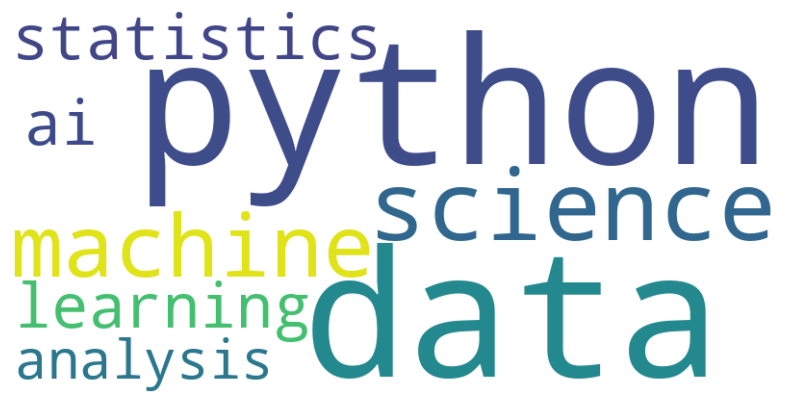

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Текст для аналізу
text = "data science python machine learning ai statistics python analysis data"

# Створення хмари слів
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Відображення хмари слів
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Тепер побудуємо WordCloud для нашого набору даних з описами вакансій.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [27]:
df = pd.read_csv('data_science_vacs.csv')

Давайте видалимо стоп-слова. Тут у нас зустрічаються українські тексти в тому числі, і завантажити стопслова для української ми можемо звідси: https://github.com/skupriienko/Ukrainian-Stopwords

In [28]:
stopwords_ua = pd.read_csv("stopwords_ua.txt", header=None, names=['stopwords'])
stopwords_ua = list(stopwords_ua.stopwords)

In [30]:
stopwords_list = stopwords_ua + stopwords.words('english')

In [31]:
text = '\n'.join(df.desc.tolist())

In [33]:
len(text)

147544

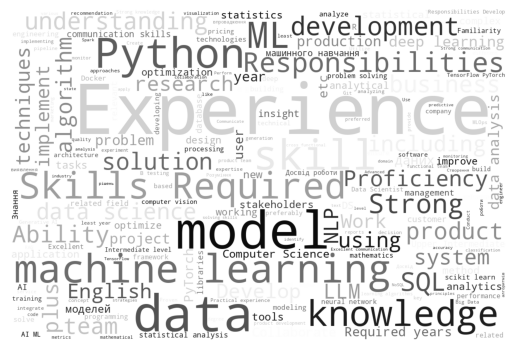

In [50]:
def create_wordcloud(text, stopwords_list):
    wc = WordCloud(
        background_color='white', 
        colormap = 'binary', 
        stopwords = stopwords_list, 
        width = 1200, 
        height = 800).generate(text)
    plt.axis("off")
    plt.imshow(wc)

create_wordcloud(text, stopwords_list)

Непогано, але можна краще.
Ця хмара слів частково відображає основні поняття, які можуть бути корисними для Data Scientist, такі як "Python", "machine learning", "NLP", "data", "model", "experience", "team". Вона дає загальне уявлення про те, що є важливим у вакансіях, але не забезпечує точного фокусу на конкретних навичках, що нам було б найцікавіше знати в такому аналізі.

Проблеми з поточною хмарою слів:
1. **Невизначеність ключових слів:**  
   У хмарі з'являються слова, які не відносяться безпосередньо до навичок, наприклад, "company", "team", "work", "experience", "product". Ці слова є занадто загальними і не дають корисної інформації про технічні чи аналітичні навички, які потребує Data Scientist.

2. **Мікс термінів:**  
   Хмара слів містить як технічні терміни (наприклад, "Python", "SQL", "machine learning"), так і загальні терміни, що можуть бути частиною опису вакансії, але не є навичками ("company", "development", "team").

   
Давайте проведемо додаткову обробку аби витягнути саме навички.

## Extract skills

Скористаємось chatGPT аби з вакансії прибрати опис вакансії і сконцентруватись на вимогах до кандидата. 

Завантажуємо для початку наш API KEY.

In [35]:
from openai import OpenAI
import json
import os

creds = json.load(open('chatgpt_4_openai_creds.json'))
os.environ['OPENAI_API_KEY'] = creds['OPENAI_API_KEY']
client = OpenAI()

In [36]:
creds.keys()

dict_keys(['OPENAI_API_KEY', 'OPENAI_CHAT_MODEL_NAME'])

```
{
    "OPENAI_API_KEY": "....",
    "OPENAI_CHAT_MODEL_NAME": "gpt-4o-mini"
}
```

In [37]:
openai_model_used = 'gpt-4o-mini'
max_tokens = 4096

def generate_messages(system_content, user_content):
    return [
        {
            "role": "system",
            "content": system_content            
        },
        {
            "role": "user",
            "content":  user_content
        }
    ]

def get_openai_response(messages, temperature=0, max_tokens=max_tokens, top_p=1):
    client = OpenAI()
    return client.chat.completions.create(
        model=openai_model_used,
        messages=messages,
        temperature=temperature,
        # max_tokens=max_tokens,
        top_p=top_p
    )

In [38]:
print(df.desc.loc[0])


What you will do● Become an expert on TransVoyant CDI™ Platform solutions and how they solve pressing customer challenges within Supply Chain and related arenas;● Identify, retrieve, manipulate, relate, and exploit multiple TransVoyant structured and unstructured data sets from thousands of various sources (ex. tweets, live aircraft, forecast weather), including building or generating new data sets as appropriate;● Create methods, models, and algorithms to understand the meaning of streaming live data, translating it into insightful predictive output for customer applications and data products;● Educate internal staff (ex. development, sales, marketing) on how data science and resulting predictions can be productized for key industry verticals;● Keep up to date on competitive solutions, products and services.Must Haves● 2+ years of cloud-based data parsing and analysis, data manipulation and transformation, and visualization experience;● Programming and scripting experience with Scala

Задамо промпт, який дозволить нам прибрати все, що не стосується безпосередньо опису навичок кандидата.

In [40]:
prompt = """
You are provided with a technical vacancy description either in English or in Ukrainian. 
Extract only skills required for a candidate and the responsibilities. Return the extracted part 
as a plain text.
Vacancy:
{}
"""
system_content = ''

In [41]:
generate_messages(system_content, prompt.format(df.desc.loc[0]))

[{'role': 'system', 'content': ''},
 {'role': 'user',
  'content': '\nYou are provided with a technical vacancy description either in English or in Ukrainian. \nExtract only skills required for a candidate and the responsibilities. Return the extracted part \nas a plain text.\nVacancy:\n\nWhat you will do● Become an\xa0expert on\xa0TransVoyant CDI™ Platform solutions and how they solve pressing customer challenges within Supply Chain and related arenas;● Identify, retrieve, manipulate, relate, and exploit multiple TransVoyant structured and unstructured data sets from thousands of\xa0various sources (ex. tweets, live aircraft, forecast weather), including building or\xa0generating new data sets as\xa0appropriate;● Create methods, models, and algorithms to\xa0understand the meaning of\xa0streaming live data, translating it\xa0into insightful predictive output for customer applications and data products;● Educate internal staff (ex. development, sales, marketing) on\xa0how data science a

In [42]:
response = get_openai_response(
    generate_messages(system_content, prompt.format(df.desc.loc[0]))
)

In [43]:
response

ChatCompletion(id='chatcmpl-AAEackqeVU1hmziahxZsxfxLgu02Y', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='**Responsibilities:**\n- Become an expert on TransVoyant CDI™ Platform solutions and how they solve pressing customer challenges within Supply Chain and related arenas.\n- Identify, retrieve, manipulate, relate, and exploit multiple TransVoyant structured and unstructured data sets from various sources (e.g., tweets, live aircraft, forecast weather), including building or generating new data sets as appropriate.\n- Create methods, models, and algorithms to understand the meaning of streaming live data, translating it into insightful predictive output for customer applications and data products.\n- Educate internal staff (e.g., development, sales, marketing) on how data science and resulting predictions can be productized for key industry verticals.\n- Keep up to date on competitive solutions, products, and services.\n\n**Skills

In [44]:
response_text = response.model_dump()['choices'][0]['message']['content']

In [45]:
print(response_text)

**Responsibilities:**
- Become an expert on TransVoyant CDI™ Platform solutions and how they solve pressing customer challenges within Supply Chain and related arenas.
- Identify, retrieve, manipulate, relate, and exploit multiple TransVoyant structured and unstructured data sets from various sources (e.g., tweets, live aircraft, forecast weather), including building or generating new data sets as appropriate.
- Create methods, models, and algorithms to understand the meaning of streaming live data, translating it into insightful predictive output for customer applications and data products.
- Educate internal staff (e.g., development, sales, marketing) on how data science and resulting predictions can be productized for key industry verticals.
- Keep up to date on competitive solutions, products, and services.

**Skills Required:**
- 2+ years of cloud-based data parsing and analysis, data manipulation and transformation, and visualization experience.
- Programming and scripting experi

In [38]:
# process all vacancies

def get_skills(vacancy):
    return get_openai_response(generate_messages(system_content, prompt.format(vacancy)))

df['skills'] = df.desc.apply(get_skills)

In [39]:
df['skills_text'] = df.skills.apply(lambda x: x.model_dump()['choices'][0]['message']['content'])

In [40]:
print(df['desc'].loc[1])


MacPaw is a software company located in Limassol, Kyiv, and Boston that develops and distributes software for macOS and iOS. At MacPaw, we believe that humans and technology can reach their greatest potential together. Today, our products have more than 30 million users worldwide.MacPaw is proud to be Ukrainian. The support and development of Ukraine are significant parts of the company’s culture. MacPaw gathers open-minded people who support each other and aspire to change the world around us.We’re looking for an experienced Product Analyst to join one of our biggest products — Setapp.Setapp is MacPaw’s subscription-based app service for macOS and iOS. It provides access to 240+ Mac and iOS apps for daily tasks covering productivity, lifestyle, web development, Mac maintenance, creativity, writing, education, and personal finance.As a Product Analyst, you will join our Purchase team. The team works closely with user accounts, billing, pricing, purchase, business models, User Flows, a

In [41]:
print(df['skills_text'].loc[1])

**Skills required:**
- 2+ years of hands-on experience in product analytics
- Strong experience with SQL
- Solid understanding of main SaaS metrics and unit economy
- Good knowledge of Tableau or another BI system
- Experience in experiment planning and analysis
- Autonomy and proactivity
- Result-oriented and comfortable with presenting findings to the team
- Knowledge of Python/R (as a plus)
- Experience with SaaS products (as a plus)
- Work experience with web analytics (GA/GTM, understanding how web analytics and web tracking work) (as a plus)
- Experience in building analytics with GDPR compliance (as a plus)

**Responsibilities:**
- Use quantitative methods to find bottlenecks and opportunities, cooperate with the team on storming and validation of hypotheses
- Design and analyze experiments to test hypotheses and build new features
- Work closely with product managers and product team to develop and measure key metrics for user accounts
- Explore and analyze data to provide acti

In [46]:
df.to_csv('data_science_vacs_enriched.csv', index=False)
df = pd.read_csv('data_science_vacs_enriched.csv')

In [48]:
# df[['desc', 'skills_text']]

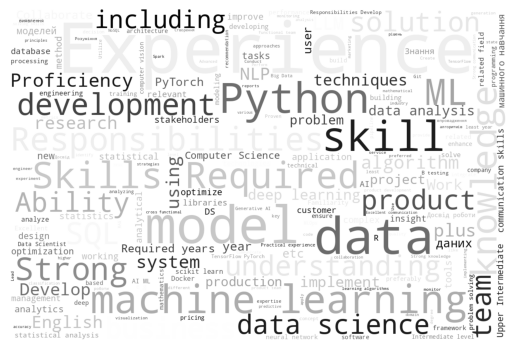

In [51]:
text = '\n'.join(df.skills_text.tolist())
create_wordcloud(text, stopwords_list)

Все ще виглядає як трошки не то. Давайте зробимо користувацький препроцесинг. 
А для початку познайомимось з поняттям n-grams.

## Що таке N-грами

**N-grams** — це послідовності з n елементів (зазвичай слів або символів), які використовуються в обробці природної мови (NLP) для аналізу тексту. N може бути будь-яким цілим числом і вказує кількість елементів у послідовності.

### Типи n-grams:
1. **Unigram (1-gram):**  
   Це окремі слова або символи в тексті. Наприклад, у реченні "I love Python", уніграми будуть:
   - I
   - love
   - Python

2. **Bigram (2-gram):**  
   Це послідовності з двох слів або символів. Для того ж речення "I love Python", біграми будуть:
   - I love
   - love Python

3. **Trigram (3-gram):**  
   Це послідовності з трьох слів або символів. У реченні "I love Python", тріграми будуть:
   - I love Python

4. **N-grams:**  
   Якщо n більше трьох, це можуть бути, наприклад, 4-grams, 5-grams тощо.

### Для чого використовують N-grams:
1. **Аналіз тексту:**  
   N-grams використовуються для виявлення частих словосполучень або шаблонів в тексті. Це особливо корисно для розуміння структури тексту або для аналізу мови.

2. **Моделювання мови:**  
   N-grams допомагають прогнозувати наступне слово в реченні на основі попередніх слів. Це ключовий підхід у задачах, таких як автозаповнення тексту чи машинний переклад.

3. **Класифікація тексту:**  
   N-grams часто використовуються як ознаки для моделювання текстової класифікації, наприклад, у задачах аналізу настроїв або виявлення спаму.

4. **Аналіз послідовностей:**  
   N-grams можуть використовуватись для аналізу біологічних послідовностей (ДНК) або інших форм послідовних даних.

### Приклад коду в Python з використанням `nltk` для генерації біграм:


In [59]:
import nltk
from nltk import ngrams

text = "I love Python programming"
tokens = nltk.word_tokenize(text)

# Генерація біграм
bigrams = list(ngrams(tokens, 2))
print(bigrams)

[('I', 'love'), ('love', 'Python'), ('Python', 'programming')]


Використаємо n-грами в нашому аналізі. В WordCloud за замовченням беруться до уваги unigrams and bigrams - можна в цьому переконатись в [сорс коді бібліотеки](https://github.com/amueller/word_cloud/blob/main/wordcloud/wordcloud.py#L598).

In [43]:
import nltk
from nltk import word_tokenize
from nltk.util import bigrams
from collections import Counter
import re

nltk.download('punkt') 

def clean_text(text):
    # Remove non-word characters
    text = re.sub(r'\W+', ' ', text).lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    # Join cleaned tokens back into a string
    return ' '.join(cleaned_tokens)

tokens = word_tokenize(clean_text(text.lower()))  # Tokenize and convert to lower case
bigram_list = list(bigrams(tokens))
bigram_freq = Counter(bigram_list)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hannapylieva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
bigram_freq_d = dict(bigram_freq)

In [45]:
bigram_freq_d = {' '.join(k):v for k, v in bigram_freq_d.items()}

In [46]:
bigram_df = pd.DataFrame(bigram_freq_d.items(), columns=['bigram', 'freq'])

In [47]:
bigram_df.sort_values(by = 'freq', ascending=False)[:30]

,bigram,freq
405,machine learning,54
80,skills required,46
66,data science,29
282,deep learning,21
460,data analysis,21
451,years experience,19
564,computer science,17
339,experience data,15
134,upper intermediate,14
2574,машинного навчання,14


In [48]:
df['contains llm'] = df.desc.str.lower().apply(lambda x: 'llm' in x or 'generative' in x)

In [49]:
df['contains neural'] = df.desc.str.lower().apply(lambda x: 'neural' in x or 'deep' in x)

In [54]:
df.to_csv('data_science_vacs_enriched.csv', index=False)

In [50]:
df['contains llm'].value_counts()

contains llm
False    41
True     16
Name: count, dtype: int64

In [58]:
df['contains neural'].value_counts()

contains neural
False    36
True     21
Name: count, dtype: int64

In [57]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

# df[df['contains llm']][['name','desc', 'link']]

In [55]:
# df[df['contains neural']][['name','desc', 'link']]